In [18]:
import os
import gzip
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from joblib import Parallel, delayed
from tqdm import tqdm
# from tqdm_joblib import tqdm_joblib
import pandas as pd
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

import netwulf as nw
import networkx as nx
from networkx.readwrite import json_graph

import community as community_louvain
import matplotlib.pyplot as plt



In [19]:
with open("network.json", "r") as f:
    graph_data = json.load(f)

# Convert the data back into a NetworkX graph object
Graph = json_graph.node_link_graph(graph_data)

In [20]:
num_nodes = Graph.number_of_nodes()
num_edges = Graph.number_of_edges()

#Solve for p using formula:
Lmax = num_nodes * (num_nodes - 1) / 2  
p = num_edges / Lmax  
print(f"Calculated probability p: {p}")

#Find k using formula
average_degree = (2 * num_edges) / num_nodes
print(f"Average degree: {average_degree}")

Calculated probability p: 0.00559690467448642
Average degree: 119.83532598542872


In [21]:
critical_point = 1/num_nodes
print(critical_point)
p > critical_point

4.670278348589576e-05


True

In [22]:
np.log(num_nodes)

9.971706791513272

In [23]:
#list of connected components:
connected_components = list(nx.connected_components(Graph))
#Finding the biggest set, from the list:
largest_component = max(connected_components, key=len)
giant_component = Graph.subgraph(largest_component)

import random
#Algortihm that approximates the shortest path lengths:
def sample_shortest_paths(graph, num_samples):
    nodes = list(graph.nodes())
    total_path_length = 0
    count = 0
    
    for _ in range(num_samples):
        node1, node2 = random.sample(nodes, 2)
        try:
            path_length = nx.shortest_path_length(graph, source=node1, target=node2)
            total_path_length += path_length
            count += 1
        except nx.NetworkXNoPath:
            continue  

    if count > 0:
        return total_path_length / count
    else:
        return float('inf') 

In [24]:
approx_average_path = sample_shortest_paths(giant_component, 10000)
print("Approximated average shortest path", approx_average_path)

Approximated average shortest path 2.6923


In [25]:
def average_dist_approximation(graph):
    N = graph.number_of_nodes()
    avg_degree = sum(dict(graph.degree()).values()) / N
    avg_shortest_path = np.log(N) / np.log(avg_degree)
    return avg_shortest_path

approx_shortest_path_real = average_dist_approximation(giant_component)

print(f"Approx distance in the Soc Sci Network: {approx_shortest_path_real}")

real_clustering = nx.average_clustering(Graph)
print(f"Global Clustering Coefficient of Real Network: {real_clustering}")

Approx distance in the Soc Sci Network: 2.0810850444799396
Global Clustering Coefficient of Real Network: 0.26209674484653656


In [32]:
partition = community_louvain.best_partition(Graph,random_state=100)

In [33]:
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")

Community 0: ['B0002J58ME', 'B001F76OKC', 'B00147FVKW', 'B0042FDCMW', 'B00B5LIE4C', 'B003X2O79W', 'B00BSB9NDK', 'B006IRQU5S', 'B001OSC4FG', 'B00612FR1I', 'B003ULW71Q', 'B000U0C9UE', 'B00012FNBI', 'B000BR4UQ2', 'B000I2JCB8', 'B00012FNB8', 'B003AFPWI2', 'B07P67V245', 'B0089PCXAS', 'B0009WFFPO', 'B00R8HWMEU', 'B00RC1YRMC', 'B00KE77JJ4', 'B005BX3O0O', 'B00049QPII', 'B00FRPK4GI', 'B00HUAGZKW', 'B00247XURC', 'B00KASQQTQ', 'B000RL21OA', 'B003HC9JJ6', 'B00429C1QQ', 'B004VB5464', 'B08MV1RJXG', 'B08M2M6WK2', 'B07K7SSSPM', 'B07KGJX6N7', 'B07KN9TM7K', 'B07KNB6D5F', 'B07G3KRYZK', 'B07DS8M656', 'B076ZS4LLX', 'B0765925D8', 'B00B2TWDWG', 'B00AZ2N906', 'B00IIOLQXU', 'B00QX5FAQA', 'B01GKKI38Y', 'B01BKTG026', 'B0044CM7YC', 'B0001ZJQ72', 'B00PRABXFO', 'B000059H6M', 'B0009WIY4S', 'B00FXCIS90', 'B00OZOIIYM', 'B00E8A0PNK', 'B0061S2T6S', 'B00R0HUEWK', 'B07T2GN9W2', 'B07DB1LKTH', 'B01M6ATZSG', 'B06Y12RK1V', 'B0012YN35M', 'B00MU1YEWW', 'B00007D00L', 'B00467182C', 'B00W85TAHE', 'B005GYXNT0', 'B000WC38CS', 'B0000

In [34]:
df = pd.read_csv("data/Merged_Reviews_and_Metadata.csv")

C:\Users\mia\AppData\Local\Temp\ipykernel_12516\1340379041.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/Merged_Reviews_and_Metadata.csv")


In [36]:
community_titles = {}
asin_to_title = dict(zip(df['parent_asin'], df['title_y']))

for comm_id, members in communities.items():
    # Skip single communities
    if len(members) < 2:
        continue

    titles = []
    for asin in members:
        if asin in asin_to_title:
            title = asin_to_title[asin]
            # Skip if the title is NaN
            if pd.isna(title):
                continue
            titles.append(title)

    # Only add the community if it has valid titles
    if titles:
        community_titles[comm_id] = titles

# Print out the movie titles for each community
for comm_id, titles in community_titles.items(): 
    print(f"Community {comm_id}:")
    for title in titles:
        print(f"  > {title}")
    print()

Community 0:
  > 10 Minute Solution: Pilates
  > Rodney Yee's Yoga for Beginners (Packaging May Vary)
  > Lots & Lots of Trucks Volume 1 - Hard Workin Trucks
  > Jane Fonda: Prime Time – Fit & Strong
  > Beachbody Shaun T's Rockin' Body DVD Workout, Dance Workout DVDs, Exercise Videos, Dancing Fitness Guide for Beginners, Seniors, Easy To Follow, Low Impact, 5 Workouts Included
  > Total Immersion Swimming: Perpetual Motion Freestyle in Ten Lessons
  > Kundalini Yoga: Green Energy of the Heart - All-In-One Workout (ALL LEVELS) by Ana Brett & Ravi Singh
  > Jillian Michaels Kickbox FastFix
  > Tricycle: Pick Your Ride Cycle with Mindy Mylrea
  > Cathe Friedrich Low Impact Cycle Max Indoor Cycling DVD - Use Cathe low impact Indoor cycling workouts for lower body sculpting, fat burning, weight loss and aerobic conditioning
  > Bob Harper: Pure Burn Super Strength
  > Viniyoga Therapy for the Low Back, Sacrum & Hips with Gary Kraftsow
  > Yoga Total Tune-UP
  > AM/PM YOGA - For Beginners &

Saving comunities

In [39]:
with open('communities.json', 'w') as file:
    json.dump(communities, file, indent=4)

Loading them again

In [42]:
with open('communities.json', 'r') as file:
    communities_test = json.load(file)

communities_test.keys(), type(communities_test), communities[0]

(dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '13', '9', '10', '11', '12', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '8']),
 dict,
 ['B0002J58ME',
  'B001F76OKC',
  'B00147FVKW',
  'B0042FDCMW',
  'B00B5LIE4C',
  'B003X2O79W',
  'B00BSB9NDK',
  'B006IRQU5S',
  'B001OSC4FG',
  'B00612FR1I',
  'B003ULW71Q',
  'B000U0C9UE',
  'B00012FNBI',
  'B000BR4UQ2',
  'B000I2JCB8',
  'B00012FNB8',
  'B003AFPWI2',
  'B07P67V245',
  'B0089PCXAS',
  'B0009WFFPO',
  'B00R8HWMEU',
  'B00RC1YRMC',
  'B00KE77JJ4',
  'B005BX3O0O',
  'B00049QPII',
  'B00FRPK4GI',
  'B00HUAGZKW',
  'B00247XURC',
 

Visulizing the Community <br>
All with communities with one member is not marked

In [ ]:
# this is using parent asin, but easier to just write asin
for comm_id, asin_list in communities_test.items(): 
    if len(asin_list) > 1:
        for asin in asin_list:
            Graph.nodes[asin]["group"] = comm_id
    else:
        Graph.nodes[asin]["group"] = 100


In [51]:
nx.get_node_attributes(Graph, "group")

{'B0002J58ME': '0',
 'B001JNNDRY': '1',
 'B001JV5BF8': '2',
 'B07QKVVKQH': '1',
 'B00Z89L6JW': '3',
 'B008UY8FKK': '4',
 'B00BY6XM5E': '4',
 'B006OAXL92': '4',
 'B004LWZW88': '4',
 'B004LWZWA6': '4',
 'B00JHH1ZN8': '1',
 'B002ZG98Z0': '2',
 'B07YTDDKSH': '1',
 'B0B6NHYWP9': '3',
 'B00009IB1D': '2',
 '0767827813': '2',
 '0767821556': '5',
 'B00N1JQ452': '3',
 'B071CKB1RF': '2',
 'B00EPA3VA2': '4',
 'B019PQ0IWY': '6',
 'B0189HKELU': '2',
 'B00NYC5II0': '7',
 'B01AH3QSEG': '6',
 'B0057RCFQS': '2',
 'B018HIZSIA': '3',
 'B00MP2FFL0': '1',
 'B00BEIYMZ6': '2',
 'B004EPZ084': '3',
 'B001F76OKC': '0',
 'B00003CXIP': '2',
 'B00A81MV3U': '2',
 'B0000VCZK2': '2',
 'B000A7DVR2': '2',
 'B000HEWEJO': '2',
 'B00MMPB6R2': '13',
 'B00005JPSM': '2',
 'B003ASLJO0': '2',
 'B001O5LVPI': '2',
 'B0042816YK': '2',
 'B005F2JRUC': '2',
 'B00008G7UF': '2',
 'B00005LOKR': '2',
 'B00008OE4W': '9',
 'B00AEFXK44': '2',
 'B00DDT0JB0': '2',
 'B001E75QH0': '2',
 'B0038M2AZA': '2',
 'B002N57KG2': '6',
 'B00407PNY2': '2',

In [56]:
for node in Graph.nodes:
    if "group" not in Graph.nodes[node]:
        Graph.nodes[node]["group"] = 100

In [57]:
nw.visualize(Graph)

(None, None)

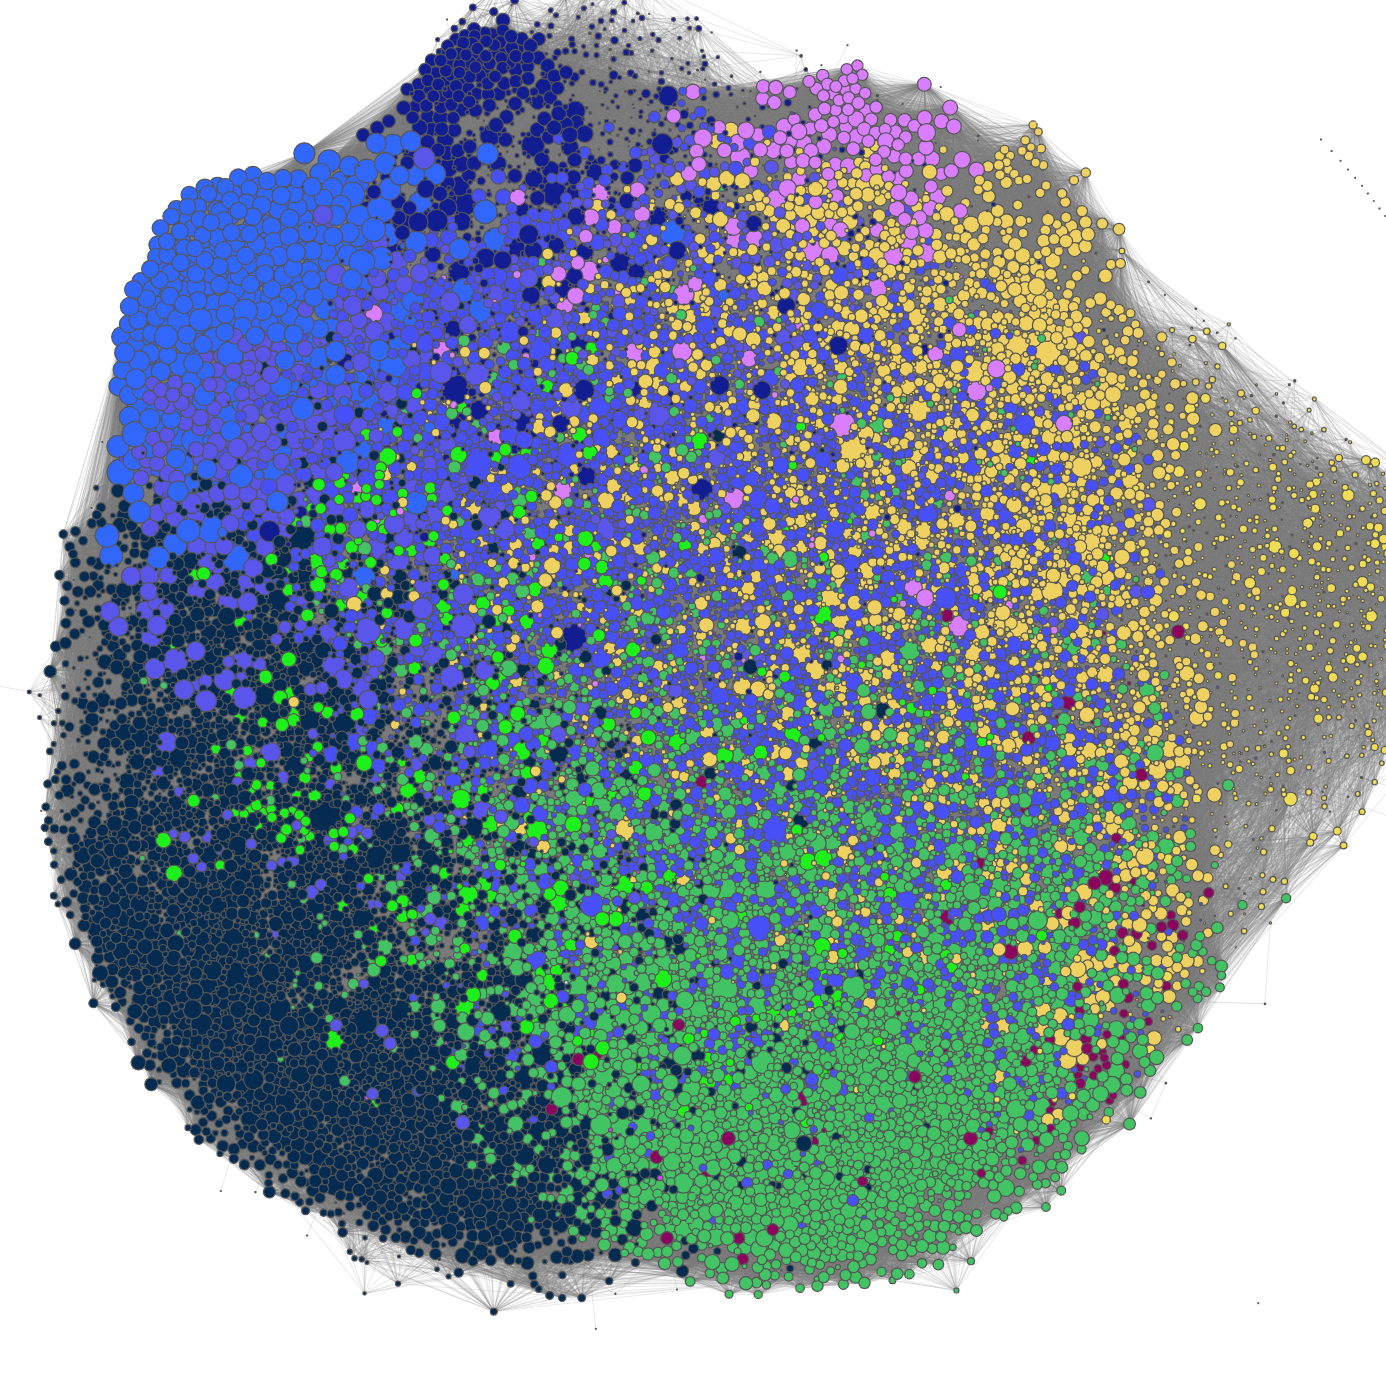

I don't know which colour matches which comunity, plus there is the "random" comunity made of all the too small ones.

---

Assortativity Coefficient

In [58]:
nx.attribute_assortativity_coefficient(Graph, "group")

0.44233023598352683

range -1 to 1, where -1 represents only connection to nodes with a different attribute. <br>
1 only connected to nodes with the same attribute. <br>
0 connects no matter the attribute

Clustering coefficient <br>
I am not sure this is what we meant?, but I couldn't find anything else in the lecture notes

In [60]:
clustering = nx.average_clustering(Graph)
clustering

0.26209674484653656